### Import Necessary Libraries

In [6]:
import os
from tqdm import tqdm
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Instatiate Costants

In [2]:
SEED = 42
PATH = '/home/ychien13/my_github/DAT490/original_datasets'
LABELS = os.listdir(PATH)
print(LABELS)

['meningioma', 'normal', 'pituitary', 'glioma']


### Load Datasets

In [3]:
images=[]
labels=[]
for type_index,cancer_type in enumerate(LABELS):
    folder_path = f'{PATH}/{cancer_type}'
    for image in tqdm(os.listdir(folder_path)):
        try:
            img=cv2.imread(os.path.join(folder_path,image))
            img = cv2.resize(img,(250,250))
            images.append(img)
            labels.append(type_index)
        except Exception as e:
            print(f'Error {e}')

labels = np.array(labels)
images = np.array(images)

 27%|██▋       | 1089/4005 [00:01<00:03, 813.89it/s]

Error OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 42%|████▏     | 1696/4005 [00:02<00:02, 859.38it/s]

Error OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 66%|██████▋   | 2659/4005 [00:03<00:01, 868.44it/s]

Error OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 4178/4178 [00:02<00:00, 1617.44it/s]


### Split and Encode dataset

In [4]:
X_train,X_test,y_train,y_test = train_test_split(images,
                                                 labels,
                                                 train_size=0.7,
                                                 test_size=0.3,
                                                 stratify=labels,
                                                 shuffle=True,
                                                 random_state=SEED
                                                )

In [7]:
encoded_y_train:np.array = to_categorical(y_train)
encoded_y_test:np.array = to_categorical(y_test)

### Create Model
> Freeze bottom layers and append a Pooling and Dense Layer for our 4 tumor brain tumor type

In [9]:
checkpoint = ModelCheckpoint("vgg16_model.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",
                             verbose=1
                            )

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

2025-04-24 00:05:09.766104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79195 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2025-04-24 00:05:09.767534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79195 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [12]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x)  
predictions = Dense(4, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [14]:
with tf.device('/GPU:0'):
    model.fit(X_train, 
          encoded_y_train, 
          epochs=10, 
          validation_split=0.2,
          verbose=True,
          batch_size=32,
          callbacks=[checkpoint]
         )

Epoch 1/10


2025-04-24 00:06:08.706342: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-24 00:06:08.831449: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-24 00:06:10.385406: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-24 00:06:11.018184: I external/local_xla/xla/service/service.cc:168] XLA service 0x153e74672fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-24 00:06:11.018236: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-04-24 00:06:11.018249: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-04-24 00:06:11.234977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc

272/272 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.8198
Epoch 1: val_accuracy improved from -inf to 0.90152, saving model to vgg16_model.keras
272/272 [==============================] - 14s 39ms/step - loss: 0.2860 - accuracy: 0.8198 - val_loss: 0.1633 - val_accuracy: 0.9015
Epoch 2/10
271/272 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9071
Epoch 2: val_accuracy did not improve from 0.90152
272/272 [==============================] - 8s 28ms/step - loss: 0.1445 - accuracy: 0.9070 - val_loss: 0.1719 - val_accuracy: 0.8882
Epoch 3/10
271/272 [============================>.] - ETA: 0s - loss: 0.1073 - accuracy: 0.9322
Epoch 3: val_accuracy improved from 0.90152 to 0.92085, saving model to vgg16_model.keras
272/272 [==============================] - 8s 30ms/step - loss: 0.1073 - accuracy: 0.9322 - val_loss: 0.1230 - val_accuracy: 0.9208
Epoch 4/10
271/272 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9564
Ep

### Model Evaluation

In [8]:
model = load_model('vgg16_model.keras')

predict = model.predict(X_test)

2025-04-24 00:34:22.519039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79195 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2025-04-24 00:34:22.522481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79195 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2025-04-24 00:34:26.065960: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-24 00:34:27.199068: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  1/146 [..............................] - ETA: 13:41

2025-04-24 00:34:31.004279: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


146/146 [==============================] - 10s 27ms/step


In [9]:
y_pred = np.argmax(predict,axis=1)
y_true = np.argmax(encoded_y_test,axis=1)
report = classification_report(y_true,y_pred)
cm = confusion_matrix(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1103
           1       0.93      0.99      0.96      1201
           2       0.98      0.96      0.97      1099
           3       0.97      0.91      0.94      1253

    accuracy                           0.95      4656
   macro avg       0.95      0.95      0.95      4656
weighted avg       0.95      0.95      0.95      4656



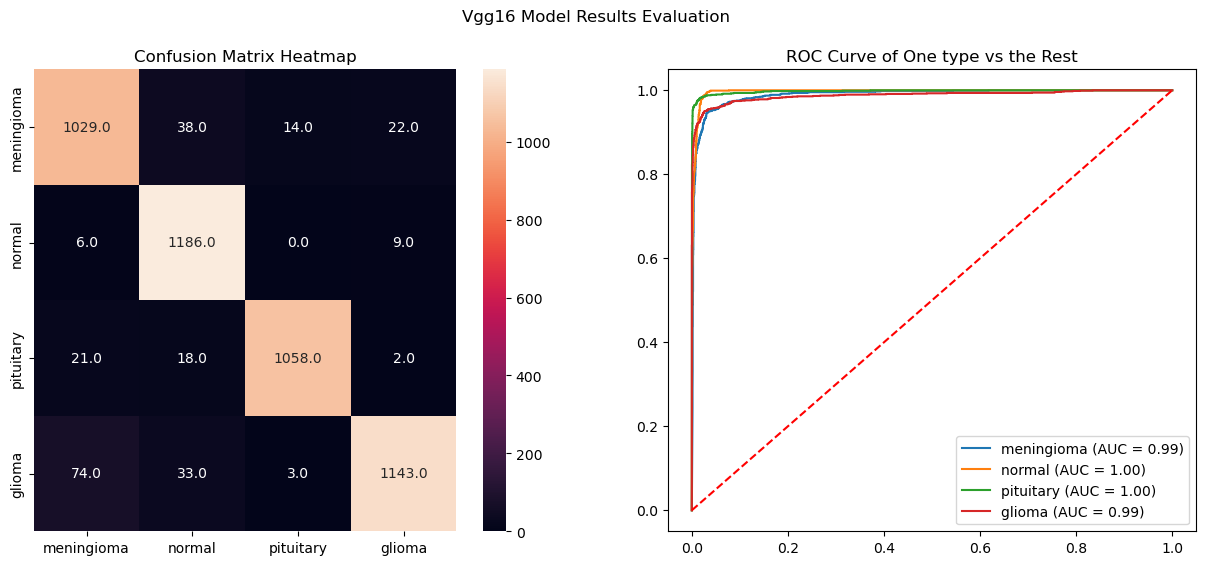

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

sns.heatmap(cm,
            xticklabels=LABELS,
            yticklabels=LABELS,
            ax=ax1,
            annot=True,
            fmt='.1f'
           )

for i in range(0,len(LABELS)):
    fpr, tpr, thresholds = roc_curve(encoded_y_test[:,i],predict[:,i])
    auc_score=auc(fpr,tpr)   
    ax2.plot(fpr,tpr,label=f'{LABELS[i]} (AUC = {auc_score:.2f})')

ax2.plot([0,1],[0,1],'r--')
ax2.legend()

fig.suptitle('Vgg16 Model Results Evaluation')
ax1.set_title('Confusion Matrix Heatmap')
ax2.set_title('ROC Curve of One type vs the Rest')

plt.show()